# FinOpt: Profile Builder

This notebook creates and saves a **financial profile** - the base configuration that describes:
- **Income**: Fixed salary + variable income (bonuses, freelancing)
- **Accounts**: Investment accounts with their return/volatility characteristics
- **Correlation**: How account returns move together

The profile is saved as JSON and can be reused across multiple scenarios in `02-scenario-optimizer.ipynb`.

## Setup

In [1]:
# --- Path setup: add project root so "src" is importable ---
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from datetime import date
from pathlib import Path

# --- Standard libs ---
import numpy as np

# --- FinOpt modules ---
from src.income import FixedIncome, IncomeModel, VariableIncome
from src.portfolio import Account
from src.model import FinancialModel
from src.serialization import save_model, load_model

---
# 1. Income Configuration

Total monthly income at time $t$ is composed of fixed and variable parts:
$$Y_t = y_t^{\text{fixed}} + Y_t^{\text{variable}}$$

## 1.1 Fixed Income (Salary)

The fixed component reflects a baseline salary subject to:
- **Annual growth** $g$: Compounded monthly as $m = (1 + g)^{1/12} - 1$
- **Scheduled raises**: Promotions or tenure milestones at specific dates

$$y_t^{\text{fixed}} = \text{current\_salary}(t) \cdot (1+m)^{\Delta t}$$

In [2]:
# --- Fixed Income Configuration ---

fixed_income = FixedIncome(
    base=1_488_000.0,       # CLP/month (base salary)
    annual_growth=0.03,     # 3% nominal annual growth
    salary_raises={
        date(2026, 4, 1): 400_000,  # +400k in April 2026 (promotion)
        date(2027, 6, 1): 400_000,  # +400k in June 2027
        date(2028, 6, 1): 300_000,  # +300k in June 2028
    },
    name="fixed"
)

print(f"Base salary: ${fixed_income.base:,.0f} CLP/month")
print(f"Annual growth: {fixed_income.annual_growth:.1%}")
print(f"Scheduled raises: {len(fixed_income.salary_raises or {})}")

Base salary: $1,488,000 CLP/month
Annual growth: 3.0%
Scheduled raises: 3


## 1.2 Variable Income (Bonuses, Freelancing)

The variable component models irregular income with:
- **Seasonality**: 12-month multiplicative factors (e.g., higher in December)
- **Noise**: Gaussian shocks $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$
- **Boundaries**: Floor and cap constraints

$$Y_t^{\text{variable}} = \text{clip}\big(\mu_t (1 + \epsilon_t), \text{floor}, \text{cap}\big)$$

In [3]:
# --- Variable Income Configuration ---

# Seasonality pattern (12 months: Jan-Dec)
# Higher values = more variable income expected that month
seasonality_variable = [
    0.00,  # Jan - low season
    0.00,  # Feb
    0.00,  # Mar
    0.60,  # Apr - tax season work
    1.00,  # May
    1.16,  # Jun - mid-year bonus
    1.00,  # Jul
    1.10,  # Aug
    0.50,  # Sep - slow month
    0.90,  # Oct
    0.85,  # Nov
    1.00,  # Dec - year-end work
]

variable_income = VariableIncome(
    base=60_000.0,              # Base variable income
    seasonality=seasonality_variable,
    sigma=0.10,                 # 10% monthly noise
    floor=0.0,                  # No negative income
    cap=400_000.0,              # Maximum 400k/month
    annual_growth=0.0,          # No growth in variable
    name="variable"
)

print(f"Base variable income: ${variable_income.base:,.0f} CLP/month")
print(f"Volatility (sigma): {variable_income.sigma:.1%}")
print(f"Floor: ${variable_income.floor:,.0f}, Cap: ${variable_income.cap:,.0f}")

Base variable income: $60,000 CLP/month
Volatility (sigma): 10.0%
Floor: $0, Cap: $400,000


## 1.3 Contribution Rates

Define what fraction of each income type goes to investments each month:
$$A_t = \alpha_{(t \mod 12)}^{f} \cdot y_t^{\text{fixed}} + \alpha_{(t \mod 12)}^{v} \cdot Y_t^{\text{variable}}$$

In [4]:
# --- Contribution Rates ---

# Fixed income contribution (per month)
# Lower in December (holiday expenses)
monthly_contrib_fixed = [
    0.45, 0.45, 0.45, 0.45, 0.45, 0.45,  # Jan-Jun: 45%
    0.45, 0.45, 0.45, 0.45, 0.45, 0.30   # Jul-Dec: 45% except Dec (30%)
]

# Variable income contribution (all of it goes to investments)
monthly_contrib_variable = [1.0] * 12  # 100% of variable income

monthly_contribution = {
    "fixed": monthly_contrib_fixed,
    "variable": monthly_contrib_variable
}

print(f"Fixed income contribution: {np.mean(monthly_contrib_fixed):.1%} average")
print(f"Variable income contribution: {np.mean(monthly_contrib_variable):.1%} average")

Fixed income contribution: 43.8% average
Variable income contribution: 100.0% average


## 1.4 Combined Income Model

In [5]:
# --- Combine into IncomeModel ---

income = IncomeModel(
    fixed=fixed_income,
    variable=variable_income,
    monthly_contribution=monthly_contribution
)

print("Income model created successfully!")
print(f"  Fixed: {income.fixed}")
print(f"  Variable: {income.variable}")

Income model created successfully!
  Fixed: FixedIncome(base=1488000.0, annual_growth=0.03, salary_raises={datetime.date(2026, 4, 1): 400000, datetime.date(2027, 6, 1): 400000, datetime.date(2028, 6, 1): 300000}, name='fixed')
  Variable: VariableIncome(base=60000.0, seasonality=(0.0, 0.0, 0.0, 0.6, 1.0, 1.16, 1.0, 1.1, 0.5, 0.9, 0.85, 1.0), sigma=0.1, floor=0.0, cap=400000.0, annual_growth=0.0, name='variable', seed=None)


---
# 2. Account Configuration

Define investment accounts with their expected returns and volatilities.

Each account is characterized by:
- **Annual return**: Expected yearly return (e.g., 8% for conservative)
- **Annual volatility**: Standard deviation of returns
- **Initial wealth**: Starting balance

In [6]:
# --- Account Configuration ---

accounts = [
    Account.from_annual(
        name="Vivienda",
        display_name="Cuenta Ahorro Vivienda (BE)",
        annual_return=0.025,
        annual_volatility=0.01,
        initial_wealth=1600000
    ),
    Account.from_annual(
        name="Clooney",
        display_name="Conservative Clooney (Fintual)",
        annual_return=0.07,
        annual_volatility=0.08,
        initial_wealth=744747
    ),
    Account.from_annual(
        name="VOO",
        display_name="VOO S&P500 ETF",
        annual_return=0.11,
        annual_volatility=0.12,
        initial_wealth=900000
    )
]

# Display account summary
print("=" * 70)
print("ACCOUNT CONFIGURATION")
print("=" * 70)
for i, acc in enumerate(accounts):
    print(f"\n{i+1}. {acc.name}")
    print(f"   Expected return: {acc.annual_params['return']:.1%}")
    print(f"   Volatility: {acc.annual_params['volatility']:.1%}")
    print(f"   Initial wealth: ${acc.initial_wealth:,.0f}")
print("\n" + "=" * 70)

ACCOUNT CONFIGURATION

1. Vivienda
   Expected return: 2.5%
   Volatility: 1.0%
   Initial wealth: $1,600,000

2. Clooney
   Expected return: 7.0%
   Volatility: 8.0%
   Initial wealth: $744,747

3. VOO
   Expected return: 11.0%
   Volatility: 12.0%
   Initial wealth: $900,000



---
# 3. Return Correlation

Define how account returns move together. The correlation matrix $\rho$ captures:
- **Diagonal = 1**: Each account is perfectly correlated with itself
- **Off-diagonal**: Cross-correlations between accounts

For example, Fintual funds may be moderately correlated ($\rho = 0.5$) since they invest in similar markets.

In [20]:
# --- Correlation Matrix ---

correlation_dict = {("Clooney", "VOO"): 0.3,
                    ("Clooney", "Vivienda"): 0.05}
correlation_dict

{('Clooney', 'VOO'): 0.3, ('Clooney', 'Vivienda'): 0.05}

---
# 4. Create Financial Model

The `FinancialModel` combines all components into a single object that can simulate wealth trajectories and run optimizations.

In [21]:
# --- Initialize FinancialModel ---

model = FinancialModel(
    income=income,
    accounts=accounts,
    default_correlation=correlation_dict
)

print(model)

FinancialModel(M=3, accounts=['Vivienda', 'Clooney', 'VOO'], cache=enabled)


In [22]:
model.returns.default_correlation

array([[1.  , 0.05, 0.  ],
       [0.05, 1.  , 0.3 ],
       [0.  , 0.3 , 1.  ]])

---
# 5. Visualize Profile (Optional)

Before saving, let's visualize the income and return projections to validate our configuration.

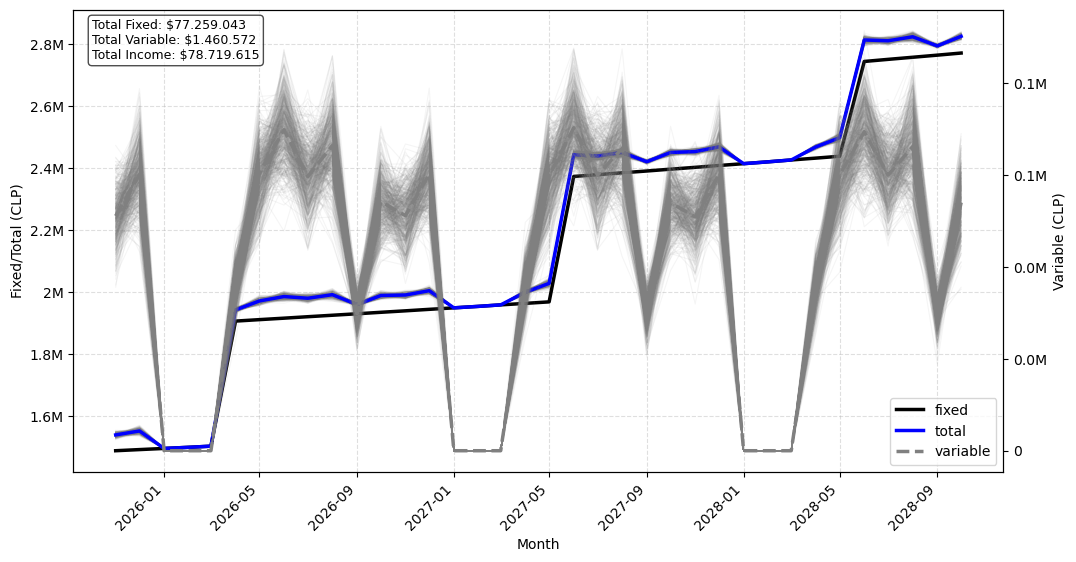

In [23]:
# --- Preview: Income Projection ---

preview_months = 36
preview_start = date(2025, 11, 1)

model.plot(mode='income', T=preview_months, start=preview_start)

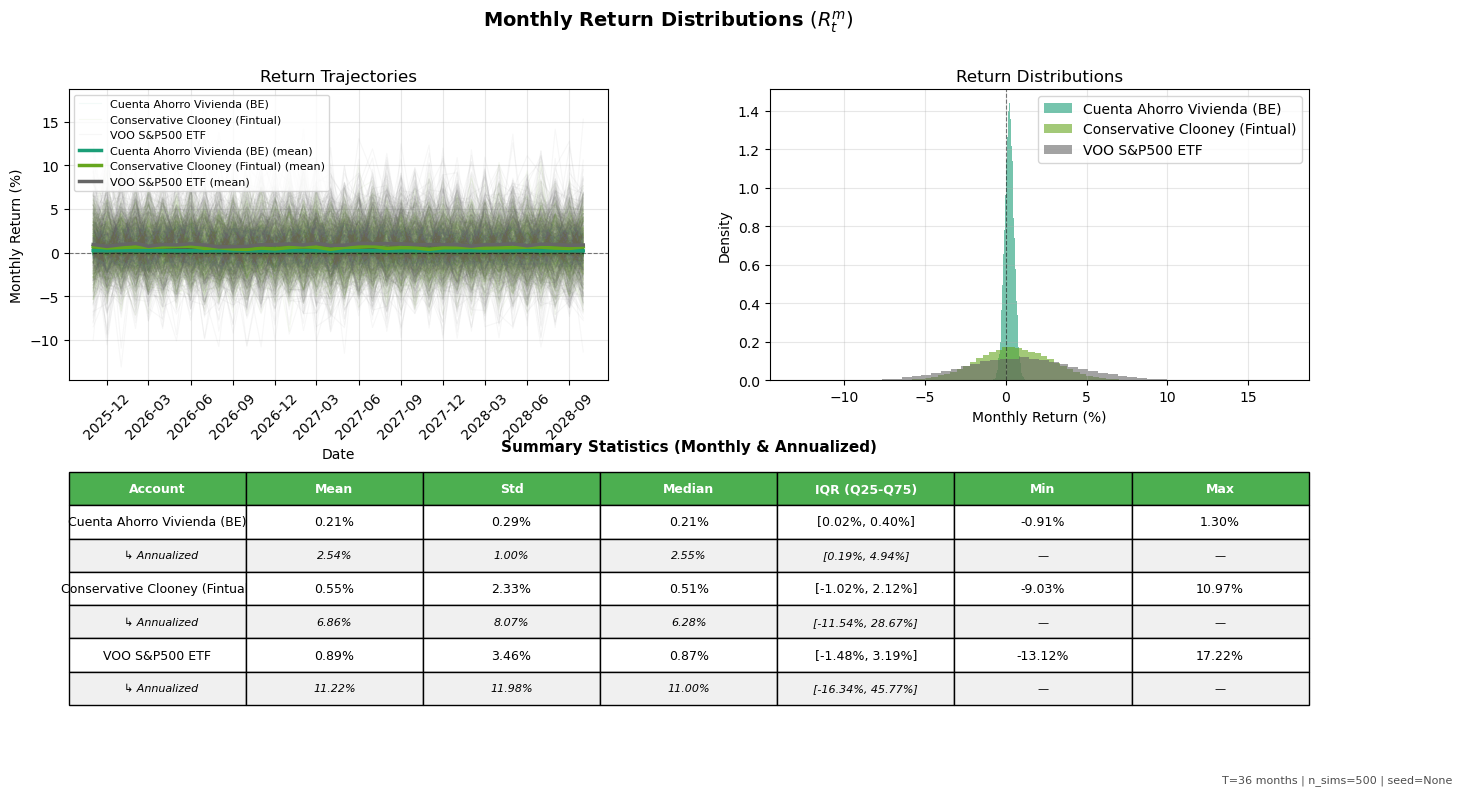

In [24]:
# --- Preview: Return Distributions ---

model.plot(mode='returns', T=preview_months, start=preview_start)

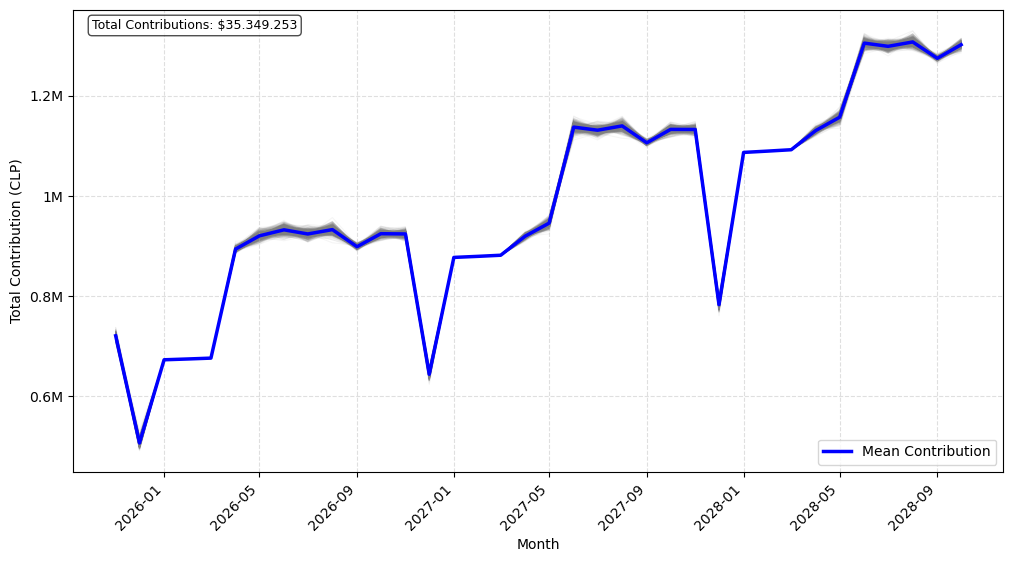

In [25]:
# --- Preview: Contribution Projection ---

model.plot(mode='contributions', T=preview_months, start=preview_start)

---
# 6. Save Profile

Save the financial profile as JSON for use in scenario optimization.

In [26]:
# --- Save Profile ---

# Create profiles directory if it doesn't exist
profiles_dir = Path("../profiles")
profiles_dir.mkdir(exist_ok=True)

# Define profile name
profile_name = "my_profile"  # Change this for different profiles
profile_path = profiles_dir / f"{profile_name}.json"

# Save
save_model(model, profile_path)

print(f"Profile saved to: {profile_path.resolve()}")
print(f"\nYou can now use this profile in 02-scenario-optimizer.ipynb")

Profile saved to: /home/mlioi/fin-opt/profiles/my_profile.json

You can now use this profile in 02-scenario-optimizer.ipynb


In [27]:
# --- Verify: Load and inspect saved profile ---

import json

with open(profile_path) as f:
    saved_config = json.load(f)

print("Saved profile structure:")
print(json.dumps(saved_config, indent=2, default=str))

Saved profile structure:
{
  "schema_version": "0.2.0",
  "income": {
    "fixed": {
      "base": 1488000.0,
      "annual_growth": 0.03,
      "salary_raises": {
        "2026-04-01": 400000,
        "2027-06-01": 400000,
        "2028-06-01": 300000
      }
    },
    "variable": {
      "base": 60000.0,
      "sigma": 0.1,
      "annual_growth": 0.0,
      "seasonality": [
        0.0,
        0.0,
        0.0,
        0.6,
        1.0,
        1.16,
        1.0,
        1.1,
        0.5,
        0.9,
        0.85,
        1.0
      ],
      "floor": 0.0,
      "cap": 400000.0
    },
    "contribution_rate_fixed": [
      0.45,
      0.45,
      0.45,
      0.45,
      0.45,
      0.45,
      0.45,
      0.45,
      0.45,
      0.45,
      0.45,
      0.3
    ],
    "contribution_rate_variable": [
      1.0,
      1.0,
      1.0,
      1.0,
      1.0,
      1.0,
      1.0,
      1.0,
      1.0,
      1.0,
      1.0,
      1.0
    ]
  },
  "accounts": [
    {
      "name": "Vivienda

In [28]:
# --- Verify: Reload and compare ---

loaded_model = load_model(profile_path)

print(f"Original model: {model}")
print(f"Loaded model:   {loaded_model}")
print(f"\nAccounts match: {[a.name for a in model.accounts] == [a.name for a in loaded_model.accounts]}")

Original model: FinancialModel(M=3, accounts=['Vivienda', 'Clooney', 'VOO'], cache=enabled)
Loaded model:   FinancialModel(M=3, accounts=['Vivienda', 'Clooney', 'VOO'], cache=enabled)

Accounts match: True


---
# Summary

You have created a financial profile containing:

| Component | Description |
|-----------|-------------|
| **Fixed Income** | Base salary with growth and scheduled raises |
| **Variable Income** | Seasonal bonuses with uncertainty |
| **Contribution Rates** | Monthly allocation to investments |
| **Accounts** | Investment vehicles with return/volatility |
| **Correlation** | How account returns co-move |

**Next step**: Open `02-scenario-optimizer.ipynb` to:
1. Load this profile
2. Define financial goals (intermediate and terminal)
3. Add withdrawal schedules
4. Run optimization to find the minimum horizon and optimal allocation